
# K最近邻简介


K最近邻属于一种估值或分类算法，他的解释很容易。
我们假设一个人的优秀成为设定为1、2、3、4、5、6、7、8、9、10数值表示，其中10表示最优秀，1表示最不优秀。
我们都知道近朱者赤，近墨者黑，我们想看一个人是什么样的，看他的朋友是什么样的就可以了。

1、如何来考察一个人？
我们通过特征属性来描述一个对象的特征，例如是否抽烟、是否运动、工资、年龄。

2、怎样才算是跟朋友亲近？
通过计算距离函数来表示两个对象的相似度。例如具有相同的习惯、兴趣

3、不同亲近程度的朋友对考察人的影响？
通过为不同距离设置权重，来表示不同近邻对待测对象的亲近度。例如5个亲近朋友中，最亲密的两个朋友对考察人物的影响非常大，其他三个朋友的影响几乎可以忽略。

4、选多少个亲近朋友来考察比较合适呢？
k的取值问题

	
**K最近邻（KNN）概念：**

它的工作原理是：存在一个样本数据集合，所有特征属性已知，并且样本集中每个对象都已知所属分类。对不知道分类的待测对象，将待测对象的每个特征属性与样本集中数据对应的特征属性进行比较，然后算法提取样本最相似对象(最近邻)的分类标签。一般来说，我们只选择样本数据集中前k个最相似的对象数据，这就是k-近邻算法中k的出处，通常k是不大于20的整数。最后根据这k个数据的特征和属性，判断待测数据的分类。

# K最近的三个基本要素


1、k值的选取。（在应用中，k值一般选择一个比较小的值，一般选用交叉验证来取最优的k值）

2、距离度量。（$L_p$距离：误差绝对值p次方求和再求p次根。欧式距离：p=2的$L_p$距离。曼哈顿距离：p=1的$L_p$距离。p为无穷大时，$L_p$距离为各个维度上距离的最大值）

3、分类决策规则。（也就是如何根据k个最近邻决定待测对象的分类。k最近邻的分类决策规则一般选用多数表决）


**KNN基本执行步骤：**

（1）计算待测对象和训练集中每个样本点的欧式距离
（2）对上面的所有距离值排序
（3）选出k个最小距离的样本作为“选民”
（4）根据“选民”预测待测样本的分类或值

**KNN特点**
（1）原理简单
（2）保存模型需要保存所有样本集
（3）训练过程很快，预测速度很慢

**优点**

简单好用，容易理解，精度高，理论成熟，既可以用来做分类也可以用来做回归；
可用于非线性分类；
可用于数值型数据和离散型数据（既可以用来估值，又可以用来分类）
训练时间复杂度为O(n)；无数据输入假定；
对异常值不敏感。
准确度高，对数据没有假设，对outlier不敏感；

**缺点：**

计算复杂性高；空间复杂性高；需要大量的内存
样本不平衡问题（即有些类别的样本数量很多，而其它样本的数量很少）；
一般数值很大的时候不用这个，计算量太大。但是单个样本又不能太少，否则容易发生误分。
最大的缺点是无法给出数据的内在含义。

**在上面的描述中思考以下问题：**

> 样本属性如何选择？如何计算两个对象间距离？当样本各属性的类型和尺度不同时如何处理？各属性不同重要程度如何处理？模型的好坏如何评估？


# 估值案例

今天我们使用k最近邻算法来构建白酒的价格模型。这是一个估值模型，不是分类案例。需要预测的回归值为白酒的价格

# 构造数据集


我们先考虑一个简单的价格模型。我们知道白酒的价格跟等级、年代有很大的关系。我们需要知道一批白酒的数据作为样本数据集，其中包含每瓶白酒的等级、年代、和价格（输出值）。

这批数据集你可以使用市场问卷调查，或者网络爬虫获取。为了简单我们自己模拟产生。

构建一个葡萄酒样本数据集。


In [20]:
from random import random,randint
import math

# 根据等级和年代对价格进行模拟
def wineprice(rating,age):
    peak_age=rating-50

    # 根据等级计算价格
    price=rating/2
    if age>peak_age:
        # 经过“峰值年”，后续5年里其品质将会变差
        price=price*(5-(age-peak_age)/2)
    else:
        # 价格在接近“峰值年”时会增加到原值的5倍
        price=price*(5*((age+1)/peak_age))
    if price<0: price=0
    return price

# 生成一批数据代表样本数据集
def wineset1():
    rows=[]
    for i in range(300):
        # 随机生成年代和等级
        rating=random()*50+50
        age=random()*50

        # 得到一个参考价格
        price=wineprice(rating,age)

        # 添加一些噪音
        price*=(random()*0.2+0.9)

        # 加入数据集
        rows.append({'input':(rating,age),'result':price})
    return rows

data = wineset1()      #创建第一批数据集


# 样本间的距离

要使用k最近邻，首先要知道哪些是最近邻，所以我们还要有一个功能，就是要能计算两个对象之间的相似度。我们这里使用欧几里得距离作为数据间的距离，代表相似度。


In [7]:
# 使用欧几里得距离，定义距离
def euclidean(v1,v2):
    d=0.0
    for i in range(len(v1)):
        d+=(v1[i]-v2[i])**2
    return math.sqrt(d)

# 获取与新数据距离最近的k个样本数据

有了样本数据集，和计算两个样本间的距离。我们就可以对待测数据，计算待测数据与样本数据集中每个样本之间的距离。并对所有距离进行排序，获取距离最近的前k个样本。

In [8]:
# 计算待测商品和样本数据集中任一商品间的距离。data样本数据集，vec1待测商品
def getdistances(data,vec1):
    distancelist=[]

    # 遍历样本数据集中的每一项
    for i in range(len(data)):
        vec2=data[i]['input']

        # 添加距离到距离列表
        distancelist.append((euclidean(vec1,vec2),i))

    # 距离排序
    distancelist.sort()
    return distancelist  #返回距离列表

# 根据距离最近的k个样本数据预测新对象的输出值

上面的步骤，我们已经获取了距离最近的k个样本对象。那么如何根据k个样本对象的属性和价格计算待测对象的价格呢？

**1、简单求均值**

In [9]:
# 对距离值最小的前k个结果求平均
def knnestimate(data,vec1,k=5):
    # 得到经过排序的距离值
    dlist=getdistances(data,vec1)
    avg=0.0

    # 对前k项结果求平均
    for i in range(k):
        idx=dlist[i][1]
        avg+=data[idx]['result']
    avg=avg/k
    return avg


**2、求加权平均**

如果使用直接求均值，有可能存在前k个最近邻中，可能会存在距离很远的数据，但是他仍然属于最近的前K个数据。

比如设定了k=5，距离最近的3个样本对象距离待测对象很近，但是第4、5个样本对象已经非常远离了待测对象。

当存在这种情况时，对前k个样本数据直接求均值会有偏差，所以使用加权平均，为较远的节点赋予较小的权值，对较近的节点赋予较大的权值。

那么具体该怎么根据数据间距离分配权值呢？这里使用三种递减函数作为权值分配方法。

三种权值分配的思想就是距离远的权值小，距离近的权值大。

**2.1、使用反函数为近邻分配权重。**

In [10]:
def inverseweight(dist,num=1.0,const=0.1):
    return num/(dist+const)

![这里写图片描述](https://img-blog.csdnimg.cn/img_convert/9576904983d7a0ca86a7a00e53155922.png)

**2.2、使用减法函数为近邻分配权重。当最近距离都大于const时不可用。**

In [11]:
def subtractweight(dist,const=1.0):
    if dist>const:
        return 0
    else:
        return const-dist

![这里写图片描述](https://img-blog.csdnimg.cn/img_convert/bb16f674261a55d96aee39bdf1c62610.png)

**2.3、使用高斯函数为距离分配权重。**

In [12]:
def gaussian(dist,sigma=5.0):
    return math.e**(-dist**2/(2*sigma**2))

![这里写图片描述](https://img-blog.csdnimg.cn/img_convert/c9e41ca14feac83015eaa94490e9e73e.png)

有了权值分配方法，下面就可以计算加权平均了。

In [21]:
# 对距离值最小的前k个结果求加权平均
def weightedknn(data,vec1,k=5,weightf=gaussian):
    # 得到距离值
    dlist=getdistances(data,vec1)
    avg=0.0
    totalweight=0.0

    # 得到加权平均
    for i in range(k):
        dist=dlist[i][0]
        idx=dlist[i][1]
        weight=weightf(dist)
        avg+=weight*data[idx]['result']
        totalweight+=weight
    if totalweight==0: return 0
    avg=avg/totalweight
    return avg

----------

以上内容，我们完成了对k最近邻的模型构造，并完成了对一个待测数据的预测。那么这个测试结果究竟好不好呢？又如何评估我们的建立的模型的好坏呢？下面我们来了解一下交叉验证。




# 交叉验证


交叉验证是一种将样本集划分为训练集和待测集，使用样本集进行模型建立，然后使用模型对待测集进行预测，并查看预测结果与真实结果之间的误差，进而对模型进行评估的方法。每划分一次样本集就相当于建立了一个模型。待测集中每一个对象都可以进行一次测试。

> 思考：交叉验证中如何将样本集划分训练集和待测集、测试多少次、有了预测结果如何计算模型好坏、能不能把预测结果返回到新的模型训练中？这些问题读者可以在今后学习中思考

交叉验证用来验证你的算法或算法参数的好坏，比如上面的加权分配算法我们有三种方式，究竟哪个更好呢？我们可以使用交叉验证进行查看。

随机选择样本数据集中95%作为训练集，5%作为待测集，对待测集中数据进行预测并与已知结果进行比较，计算准确率，查看算法效果。

> 读者需要注意，交叉验证中并不是一定使用准确率来判断模型好坏，只不过准确率是用的最多的评估标准。

下面使用代码实现交叉验证。

首先实现将样本数据集划分为训练集和待测集两个子集的功能。

In [22]:
# 划分数据。test待测集占的比例。其他数据为训练集
def dividedata(data,test=0.05):
    trainset=[]
    testset=[]
    for row in data:
        if random()<test:
            testset.append(row)
        else:
            trainset.append(row)
    return trainset,testset

然后再来计算预测结果与真实结果之间的准确率。以此来表示系统模型的好坏。

In [23]:
# 对使用算法进行预测的结果的误差进行统计，以此判断算法好坏。algf为算法函数，trainset为训练数据集，testset为待测数据集
def testalgorithm(algf,trainset,testset):
    error=0.0
    for row in testset:
        guess=algf(trainset,row['input'])   #这一步要和样本数据的格式保持一致，列表内个元素为一个字典，每个字典包含input和result两个属性。而且函数参数是列表和元组
        error+=(row['result']-guess)**2
        #print row['result'],guess
    #print error/len(testset)
    return error/len(testset)

有了数据拆分和算法性能误差统计函数。我们就可以在原始数据集上进行多次这样的拆分统计实验，计算平均误差。

In [24]:
# 将数据拆分和误差统计合并在一起。对数据集进行多次划分，并验证算法好坏
def crossvalidate(algf,data,trials=100,test=0.1):
    error=0.0
    for i in range(trials):
        trainset,testset=dividedata(data,test)
        error+=testalgorithm(algf,trainset,testset)
    return error/trials

上面我们完成了交叉验证的全部功能，下面我们来尝试一下应用这个功能。

交叉验证测试

In [26]:
data = wineset1()      #创建第一批数据集
# print(data)
error = crossvalidate(knnestimate,data)   #对直接求均值算法进行评估
print('平均误差：'+str(error))

def knn3(d,v): return knnestimate(d,v,k=3)  #定义一个函数指针。参数为d列表，v元组
error = crossvalidate(knn3, data)            #对直接求均值算法进行评估
print('平均误差：' + str(error))

def knninverse(d,v): return weightedknn(d,v,weightf=inverseweight)  #定义一个函数指针。参数为d列表，v元组
error = crossvalidate(knninverse, data)            #对使用反函数做权值分配方法进行评估
print('平均误差：' + str(error))

平均误差：286.47110528978357
平均误差：250.03608805220637
平均误差：220.68960367069892



----------


上面我们已经完成了knn模型的建模和使用。以及使用交叉验证完成对模型中算法的选择和模型的评估。


----------

下面我们来看一些复杂的情况。


# 不同类型、尺度的属性，无用属性


实际生活中，白酒的价格不仅与年代和等级有关系，还与酒瓶容量等其他属性有很大的关系。
所以我们这里来讨论一下当样本数据集中可能存在复杂属性的情况。

1、属性类型不同，属性尺度不同的情况

在样本数据集中的对象各个属性可能并不是取值范围相同、类型相同的数值，比如上面的酒的属性可能包含档次（0-100），酒的年限（0-50），酒的容量（三种容量375.0ml、750.0ml、1500.0ml），

2、存在无效属性的情况

在我们获取的样本数据中还有可能包含无用的属性，比如酒箱的号码（1-2000之间的整数）。在计算样本距离时，取值范围大的属性的变化会严重影响取值范围小的属性的变化，以至于结果会忽略取值范围小的属性。而且无用属性的变化也会增加数据之间的距离。比如两瓶非常相似的酒，两瓶酒之间的距离本应为接近0，但是由于两瓶酒的酒箱号码分别为1和100，则在计算两瓶酒之间的距离时就会接近100。而这属于一个很大的距离。


针对上面的情况，要求我们能对样本数据的属性进行缩放到合适的范围，并要能删除无效属性。

我们先来模拟构造一批数据集，这批数据集本应是网络爬虫获取或市场统计获取。为了简单我们使用代码模拟获取这么一批数据。它包含了酒的档次、年限、容量、酒箱的号码以及酒的价格。

**构造新的数据集**

In [27]:
# 构建新数据集，模拟不同类型、尺度的属性
def wineset2():
    rows=[]
    for i in range(300):
        rating=random()*50+50   #酒的档次
        age=random()*50         #酒的年限
        aisle=float(randint(1,2000))  #酒箱的号码（无关属性）
        bottlesize=[375.0,750.0,1500.0][randint(0,2)]  #酒的容量
        price=wineprice(rating,age)  #酒的价格
        price*=(bottlesize/750)
        price*=(random()*0.2+0.9)
        rows.append({'input':(rating,age,aisle,bottlesize),'result':price})
    return rows

**实现按比例对属性的取值进行缩放的功能**

In [28]:
# 按比例对属性进行缩放，scale为各属性的值的缩放比例。
def rescale(data,scale):
    scaleddata=[]
    for row in data:
        scaled=[scale[i]*row['input'][i] for i in range(len(scale))]
        scaleddata.append({'input':scaled,'result':row['result']})
    return scaleddata


那就还剩一个问题，究竟各个属性缩放多少才合适呢。这是一个优化问题，我们可以通过优化技术寻找最优化解。

优化，就是寻找函数极值点的问题。寻找在一定自变量范围内使函数值最小或最大的自变量的取值。函数一般设定为成本函数，自变量为函数的参数，也就是算法的参数。参数和函数值可以是离散或连续值。


比如属性比例缩放，每个属性的缩放比例就是自变量，成本函数就是预测结果的错误率，寻找方法就是简单的暴力尝试每一个自变量的值，寻找使成本函数最小的自变量。

而需要优化的成本函数，就是通过缩放以后进行预测的结果与真实结果之间的误差值。误差值越小越好。误差值的计算同前面交叉验证时使用的相同crossvalidate函数



下面构建成本函数

In [29]:
# 生成成本函数。
def createcostfunction(algf,data):
    def costf(scale):
        sdata=rescale(data,scale)
        return crossvalidate(algf,sdata,trials=10)
    return costf

weightdomain=[(0,10)]*4     #将缩放比例这个题解的取值范围设置为0-10，可以自己设定，用于优化算法

我们通过优化技术查找到了所有属性合适的缩放比例，我们也就可以对样本数据集的属性进行缩放后建立k最近邻模型。当有待测数据到来时，我们也对待测对象的属性进行缩放后，与模型中的对象（比例缩放后的样本对象）进行距离计算，获取k最近邻。

测试代码

In [36]:
! pip install optimization

Looking in indexes: https://mirrors.tencent.com/pypi/simple/, https://mirrors.tencent.com/repository/pypi/tencent_pypi/simple
  Using cached https://mirrors.tencent.com/pypi/packages/f2/94/3af39d34be01a24a6e65433d19e107099374224905f1e0cc6bbe1fd22a2f/argparse-1.4.0-py2.py3-none-any.whl (23 kB)
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [44]:
# ======================缩放比例优化======================
data = wineset2()  # 创建第2批数据集
# print(data)
import optimization
costf=createcostfunction(knnestimate,data)      #创建成本函数
result = optimization.annealingoptimize(weightdomain,costf,step=2)    #使用退火算法寻找最优解
print(result)

ModuleNotFoundError: No module named 'optimization'


上面我们又解决了一种带有不同类型、尺度的属性，无用属性等复杂属性的情况，这是数据来源的问题，下面我们将面临最后一个问题，是输出结果的问题。



预测结果的不对称分布
-----

我们上面建立的酒的价格模型。这是正规市场中的酒。但是如何这酒是逃税酒，那么逃税酒的价格仍然和酒的等级、年份、容量有相似的关系，不过比正规酒要便宜40%。而我们买一瓶酒时并不知道这是正规酒就还是逃税酒。因此当我们预测价格时我们更情愿说如果这酒是正规酒，则价格大约是m1元，如果是逃税酒，这价格是m2元。

当然还有另外一种结果输出的形式，就是n1%的概率是m1元，n2%的概率是m2元，这种概率输出方式。

在数据挖掘中，对于样本数据集包含多种分布情况时，待测对象的预测结果我们也希望不唯一的表示。我们可以使用概率结果进行表示，输出每种结果的值和出现的概率。

我们模拟一批数据，样本数据中价格存在正规酒和逃税酒这两种形式的分布。

**构造数据集**


In [38]:
def wineset3():
    rows=wineset1()
    for row in rows:
        if random()<0.5:
            # 一半的可能是逃税酒
            row['result']*=0.6
    return rows

如果以结果概率的形式存在，首先我们要能够计算概率值

In [39]:
# 计算概率。data样本数据集，vec1预测数据，low，high结果范围，weightf为根据距离进行权值分配的函数
def probguess(data,vec1,low,high,k=5,weightf=gaussian):
    dlist=getdistances(data,vec1)  #获取距离列表
    nweight=0.0
    tweight=0.0

    for i in range(k):
        dist=dlist[i][0]   #距离
        idx=dlist[i][1]   #酒箱的号码
        weight=weightf(dist)  #权值
        v=data[idx]['result']  #真实结果

        # 当前数据点位于指定范围内么？
        if v>=low and v<=high:
            nweight+=weight    #指定范围的权值之和
        tweight+=weight        #总的权值之和
    if tweight==0: return 0

    # 概率等于位于指定范围内的权重值除以所有权重值
    return nweight/tweight

对于多种输出、以概率和值的形式表示的结果，我们可以使用累积概率分布图或概率密度图的形式表现。

**绘制累积概率分布图**

In [40]:
from pylab import *

# 绘制累积概率分布图。data样本数据集，vec1预测数据，high取值最高点，k近邻范围，weightf权值分配
def cumulativegraph(data,vec1,high,k=5,weightf=gaussian):
    t1=arange(0.0,high,0.1)
    cprob=array([probguess(data,vec1,0,v,k,weightf) for v in t1])   #预测产生的不同结果的概率
    plot(t1,cprob)
    show()

**绘制概率密度图**

In [41]:
# 绘制概率密度图
def probabilitygraph(data,vec1,high,k=5,weightf=gaussian,ss=5.0):
    # 建立一个代表价格的值域范围
    t1=arange(0.0,high,0.1)

    # 得到整个值域范围内的所有概率
    probs=[probguess(data,vec1,v,v+0.1,k,weightf) for v in t1]

    # 通过加上近邻概率的高斯计算结果，对概率值做平滑处理
    smoothed=[]
    for i in range(len(probs)):
        sv=0.0
        for j in range(0,len(probs)):
            dist=abs(i-j)*0.1
            weight=gaussian(dist,sigma=ss)
            sv+=weight*probs[j]
        smoothed.append(sv)
    smoothed=array(smoothed)

    plot(t1,smoothed)
    show()

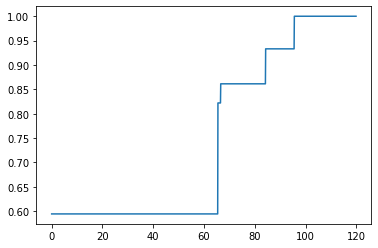

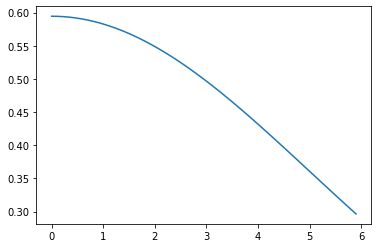

In [43]:
data = wineset3()  # 创建第3批数据集
# print(data)
cumulativegraph(data,(1,1),120)   #绘制累积概率密度
probabilitygraph(data,(1,1),6)    #绘制概率密度图

# k近邻算法中k的选取以及特征归一化的重要性


如果我们选取较小的k值，那么就会意味着我们的整体模型会变得复杂，容易发生过拟合。因为k太小会导致过拟合，很容易将一些噪声（如上图离五边形很近的黑色圆点）学习到模型中，而忽略了数据真实的分布！

如果k值太大就会造成模型过于简单，完全忽略训练数据实例中的大量有用信息，是不可取的。

那么我们一般怎么选取呢？李航博士书上讲到，我们一般选取一个较小的数值，通常采取 交叉验证法来选取最优的k值。（也就是说，选取k值很重要的关键是实验调参，类似于神经网络选取多少层这种，通过调整超参数来得到一个较好的结果）
